In [1]:
import sys
sys.path.append("/vol/bitbucket/ad6013/Research/gp-causal")
import numpy as np
import matplotlib.pyplot as plt

import pickle

In [2]:
file_2 = "/vol/bitbucket/ad6013/Research/gp-causal/results/fullscore-sim-2-gplvm-sqexp-reinit20.p"


with open(file_2, "rb") as f:
    results_2 = pickle.load(f)

In [3]:
file_1 = "/vol/bitbucket/ad6013/Research/gp-causal/results/fullscore-sim-gplvm-sqexp-reinit20.p"


with open(file_1, "rb") as f:
    results_1 = pickle.load(f)

In [4]:
# log odds will be causal hypothesis over anticausal
scores_1 = {}
for idx, i in enumerate(results_1['scores']):
    if idx > 49:
        break
    causal = i[0]
    anti_causal = i[1]
    scores_1[idx] = (causal, anti_causal)
    if sum(causal) > sum(anti_causal):
        print(idx)

1
8
9
10
11
13
15
18
23
25
31
33
38
39
46
48


In [5]:
# log odds will be causal hypothesis over anticausal
scores_2 = {}
for idx, i in enumerate(results_2[1]):
    idx += 50
    causal = i[0]
    anti_causal = i[1]
    scores_2[idx] = (causal, anti_causal)
    if sum(causal) > sum(anti_causal):
        print(idx)

55
58
63
71
74
76
84
87


In [6]:
file_3 = "/vol/bitbucket/ad6013/Research/gp-causal/results/fullscore-sim-gplvm-sqexp-reinit5-numind110.p"


with open(file_3, "rb") as f:
    results_3 = pickle.load(f)

In [7]:
wrong = [1,
    8,
    9,
    10,
    11,
    13,
    15,
    18,
    23,
    25,
    31,
    33,
    38,
    39,
    46,
    48,
    55,
    58,
    63,
    71,
    74,
    76,
    84,
    87]
scores_3 = {}
for idx, i in enumerate(results_3['scores']):
    causal = i[0]
    anti_causal = i[1]
    scores_3[wrong[idx]] = (causal, anti_causal)

In [8]:
if 50 in scores_2.keys():
    print(1)

1


In [9]:
final_scores = {}
all_log_diffs = {}
correct_idx = []
wrong_idx = []
for i in range(100):
    if i in scores_3.keys():
        causal_x_3 = scores_3[i][0][0]
        causal_y_x_3 = scores_3[i][0][1]
        anticausal_y_3 = scores_3[i][1][0]
        anticausal_x_y_3 = scores_3[i][1][1]
        compare = True
    else:
        compare = False 
    if i in scores_1.keys():
        causal_x = scores_1[i][0][0]
        causal_y_x = scores_1[i][0][1]
        anticausal_y = scores_1[i][1][0]
        anticausal_x_y = scores_1[i][1][1]
    elif i in scores_2.keys():
        causal_x = scores_2[i][0][0]
        causal_y_x = scores_2[i][0][1]
        anticausal_y = scores_2[i][1][0]
        anticausal_x_y = scores_2[i][1][1]
    else:
        raise ValueError(f"{i} not found in results!")
    if compare:
        final_causal_x = min(causal_x, causal_x_3)
        final_causal_y_x = min(causal_y_x, causal_y_x_3)
        final_anticausal_y = min(anticausal_y, anticausal_y_3)
        final_anticausal_x_y = min(anticausal_x_y, anticausal_x_y_3)
    else:
        final_causal_x = causal_x
        final_causal_y_x = causal_y_x
        final_anticausal_y = anticausal_y
        final_anticausal_x_y = anticausal_x_y
    final_scores[i] = (
        (final_causal_x, final_causal_y_x),
        (final_anticausal_y, final_anticausal_x_y)
    )
    score_causal = final_causal_x + final_causal_y_x
    score_anticausal = final_anticausal_y + final_anticausal_x_y
    log_diff = score_causal - score_anticausal
    all_log_diffs[i] = log_diff
    if log_diff < 0:
        correct_idx.append(i)
    elif log_diff > 0:
        wrong_idx.append(i)
    else:
        print(
            f"Undecided: {i}"
        )


In [10]:
wrong_idx

[1, 8, 9, 10, 11, 13, 15, 23, 25, 31, 33, 38, 39, 55, 58, 71, 74, 76, 84, 87]

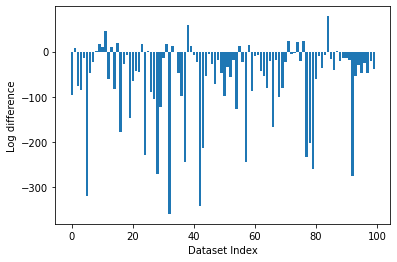

In [11]:
plt.bar(np.arange(len(all_log_diffs)), list(all_log_diffs.values()))
plt.ylabel("Log difference")
plt.xlabel("Dataset Index")
# plt.ylim(-400, 200)
plt.show()

In [12]:
# Calculate ROC curve and AUC 
# The score value should be - causal + anticausal
# This is because a higher score should mean causal and a lower score mean anticausal

# We also need to ensure half the labels are anticausal and half the labels are causal
# We thus need to generate indexes that will be the anticausal direction is true
# then for the other ones, we will multiply the scores by -1

anticausal_labels = np.random.choice(100, 50, replace=False)
causal_labels = np.array(
    list(
        set(np.arange(100)) - set(anticausal_labels)
    )
)
y_labels = np.zeros(100)
y_scores = np.zeros(100)
for i in range(100):
    if i in anticausal_labels:
        y_labels[i] = -1
        y_scores[i] = all_log_diffs[i]
    elif i in causal_labels:
        y_labels[i] = 1
        y_scores[i] = -1 * all_log_diffs[i]
    else:
        raise ValueError(f"Missed {i}")
    

In [13]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_curve, auc


fpr, tpr, _ = roc_curve(y_labels, y_scores)
roc_auc = auc(fpr, tpr)

In [14]:
roc_auc

0.8996000000000001

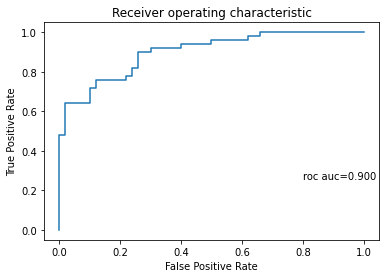

In [15]:
textstr = 'roc auc=%.3f\n'%(
    roc_auc
)
plt.text(0.8, 0.2, textstr, fontsize=10)
plt.plot(
    fpr, tpr
)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.show()

In [16]:
file = "/vol/bitbucket/ad6013/Research/gp-causal/results/fullscore-cep-gplvm-sqexp-reinit20.p"


with open(file, "rb") as f:
    results_tub = pickle.load(f)

In [17]:
corr, wrong, weight = results_tub["correct_idx"], results_tub["wrong_idx"], results_tub["weight"]
correct_weight = [weight[i] for i in corr]
wrong_weight = [weight[i] for i in wrong]
accuracy = np.sum(correct_weight) / (np.sum(correct_weight) + np.sum(wrong_weight))
print(f"\n Final accuracy: {accuracy}")


 Final accuracy: 0.6751023446222553


In [18]:
# log odds will be causal hypothesis over anticausal
log_odds_tub = []
for i in results_tub['scores']:
    causal = sum(i[0])
    anti_causal = sum(i[1])
    log_odds_tub.append(causal - anti_causal)

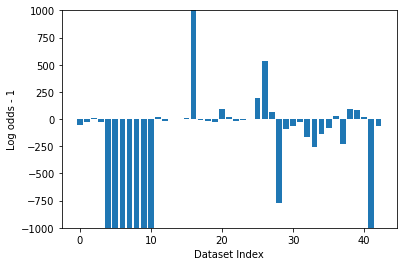

In [19]:
plt.bar(np.arange(len(log_odds_tub)), log_odds_tub)
plt.ylabel("Log odds - 1")
plt.xlabel("Dataset Index")
plt.ylim(-1000, 1000)
plt.show()

In [20]:
for idx, i in enumerate(log_odds_tub):
    print(
        f"{idx}, {i}"
    )


0, -58.76775580368246
1, -29.271284992371648
2, 5.444958032654995
3, -24.85126765075836
4, -6793.200733946684
5, -6791.042361109217
6, -3204.7850324804203
7, -3039.4245472529383
8, -3259.47271836702
9, -3258.417519880637
10, -3277.7193443540273
11, 18.309072591539007
12, -15.191325387190204
13, -3.0585648516163246
14, 3.348652760825644
15, 6.62747247219977
16, 9238.280529292864
17, -9.94984516822285
18, -15.494050632047674
19, -28.30637239151281
20, 94.65895082761631
21, 19.0851542336718
22, -21.773354030336804
23, -5.973443867824244
24, -2.655142919832997
25, 189.74702789557068
26, 529.873469576683
27, 66.12003965087115
28, -772.5473983240859
29, -90.46507534479179
30, -66.35001801947374
31, -23.445595758407535
32, -163.42221462529005
33, -256.4222602284218
34, -139.66086704732038
35, -78.10410591123707
36, 30.30972383912308
37, -230.4034228531914
38, 90.78074737329052
39, 84.92132219471614
40, 22.14295212223078
41, -1203.1253068311053
42, -66.21195299151259


In [21]:
Correct: 40, Wrong: 17
Correct: 42, Wrong: 8

SyntaxError: invalid syntax (300375016.py, line 1)

In [ ]:
wrong_idx

[1,
 8,
 9,
 10,
 11,
 13,
 15,
 18,
 23,
 25,
 31,
 33,
 38,
 39,
 46,
 48,
 53,
 55,
 62,
 63,
 74,
 78,
 80,
 81,
 82,
 84,
 93,
 96]

Load cause-effect pairs: 100%|██████████| 100/100 [00:00<00:00, 387.74it/s]



 1: 7.947008861534641


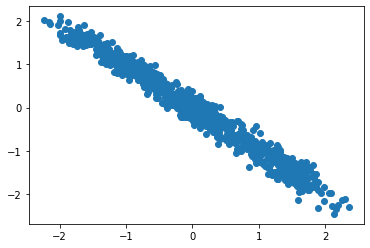


 8: 2.125546451411992


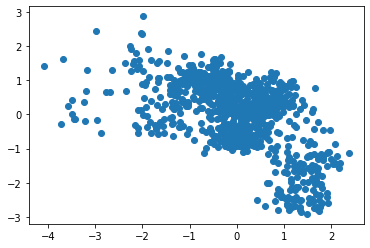


 9: 16.788658202864553


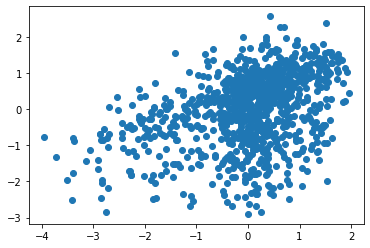


 10: 10.139711391789888


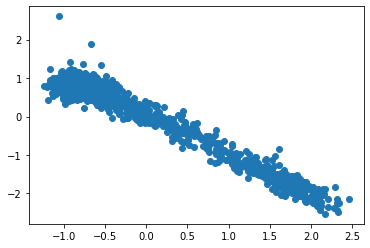


 11: 45.089589420741504


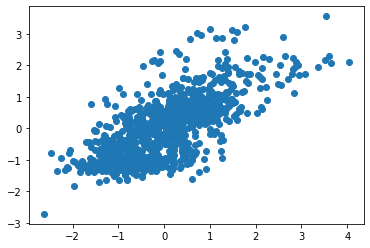


 13: 10.884235865943992


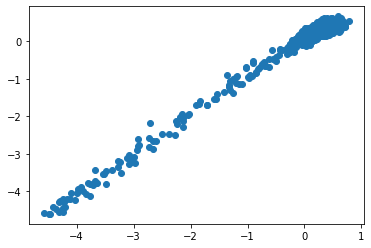


 15: 18.898060491425667


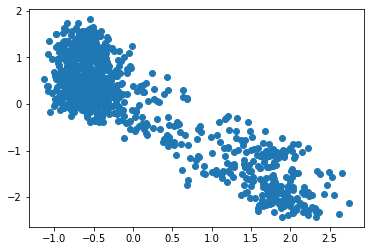


 23: 16.997171716323237


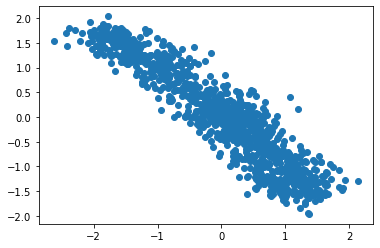


 25: 0.3289264679892767


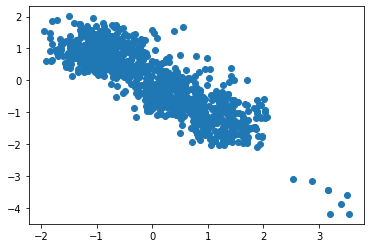


 31: 16.01142022572776


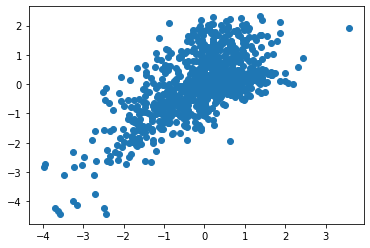


 33: 12.203888514887922


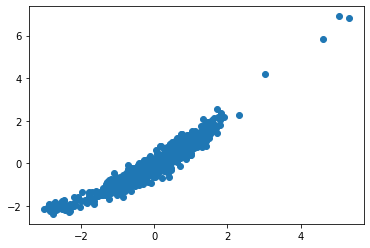


 38: 58.6196489362797


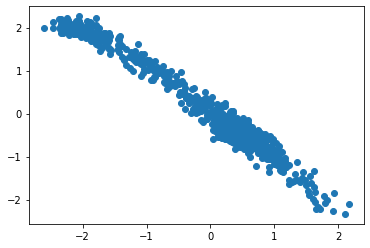


 39: 12.681931798781761


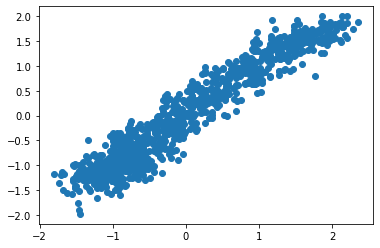


 55: 13.092166779384797


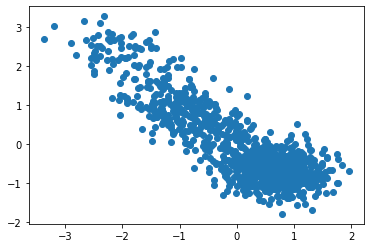


 58: 14.075042705045234


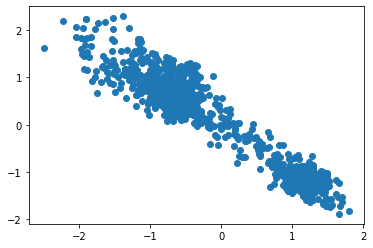


 71: 22.810219311423452


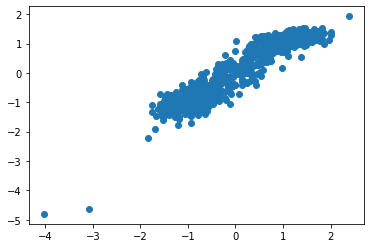


 74: 20.271401595046882


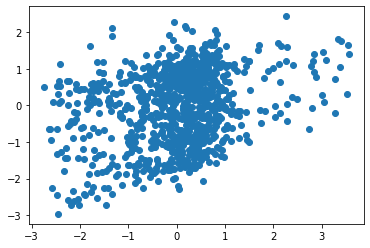


 76: 24.068180483076503


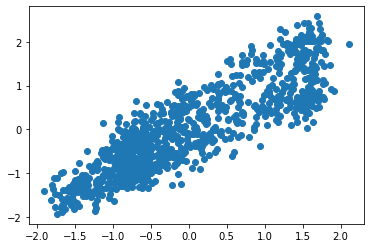


 84: 78.07925873321528


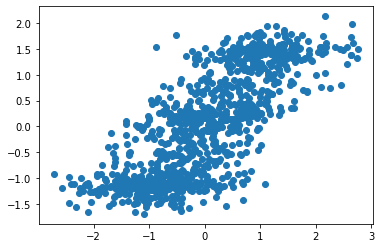


 87: 0.6112850384004105


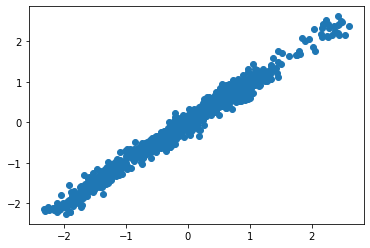

In [ ]:
# Plot the results that we got wrong
from data.get_data import get_simulated_pairs_dataset


x, y, weight = get_simulated_pairs_dataset(
    data_path='/vol/bitbucket/ad6013/Research/gp-causal/data/sim_pairs/files'
)

for i in range(100):
    if i in wrong_idx:
        input, output = x[i], y[i]
        input = (input - input.mean(axis=0)[:, None]) / input.std(axis=0)[:, None]
        output = (output - output.mean(axis=0)[:, None]) / output.std(axis=0)[:, None]
        print(f"\n {i}: {all_log_diffs[i]}")
        plt.scatter(input[:, 0], output[:, 0])
        plt.show()

# Cha pairs results analysis

In [ ]:
import sys
sys.path.append("/vol/bitbucket/ad6013/Research/gp-causal")

In [22]:
import pickle 
import matplotlib.pyplot as plt
import numpy as np


work_dir = "/vol/bitbucket/ad6013/Research/gp-causal"
file = "fullscore-cha_pairs-gplvm-reinit20-numind200_start:0_end:150.p"
file_2 = "fullscore-cha_pairs-gplvm-reinit20-numind200_start:150_end:300.p"

In [23]:
with open(f"{work_dir}/results/{file}", "rb") as f:
    results = pickle.load(f)
with open(f"{work_dir}/results/{file_2}", "rb") as f:
    results_2 = pickle.load(f)

In [24]:
from data.get_data import get_cha_pairs_dataset


x, y, weight, target = get_cha_pairs_dataset(data_path=f"{work_dir}/data/cha_pairs/files")

In [25]:
num_runs_1 = len(results['scores'])
num_runs_2 = len(results_2['scores']) 

y_labels = np.zeros(num_runs_1 + num_runs_2)
y_scores = np.zeros(num_runs_1 + num_runs_2)
# causal labels are 1 thus we need to multiply all scores by -1
for i in range(num_runs_1):
    y_label_i = target[i][0]
    y_labels[i] = y_label_i
    # Calculate the score
    # This is a tuple
    scores = results['scores'][i]
    causal = sum(scores[0])
    anti_causal = sum(scores[1])
    final_score = - causal + anti_causal
    y_scores[i] = final_score
for i in range(150, 150 + num_runs_2):
    idx = i - 150 + num_runs_1
    y_label_i = target[i][0]
    y_labels[idx] = y_label_i
    # Calculate the score
    # This is a tuple
    scores = results_2['scores'][i - 150]
    causal = sum(scores[0])
    anti_causal = sum(scores[1])
    final_score = - causal + anti_causal
    y_scores[idx] = final_score


In [26]:
print(num_runs_1 + num_runs_2)

237


In [27]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score


fpr, tpr, _ = roc_curve(y_labels, y_scores)
roc_auc = auc(fpr, tpr)


In [28]:
roc_auc

0.8152142857142858

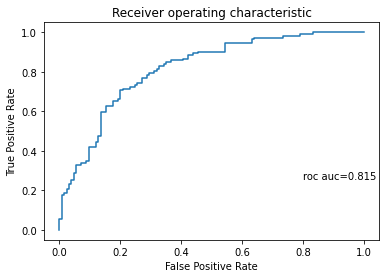

In [29]:
textstr = 'roc auc=%.3f\n'%(
    roc_auc
)
plt.text(0.8, 0.2, textstr, fontsize=10)
plt.plot(
    fpr, tpr
)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.show()

# Gauss pairs results analysis

In [52]:
import sys
sys.path.append("/vol/bitbucket/ad6013/Research/gp-causal")

In [64]:
import pickle 
import matplotlib.pyplot as plt
import numpy as np



work_dir = "/vol/bitbucket/ad6013/Research/gp-causal"
file_1 = "fullscore-multi_pairs-gplvm-reinit20-numind200_start:0_end:20.p"
file_2 = "fullscore-multi_pairs-gplvm-reinit20-numind200_start:20_end:40.p"
file_3 = "fullscore-multi_pairs-gplvm-reinit20-numind200_start:40_end:60.p"
file_4 = "fullscore-multi_pairs-gplvm-reinit20-numind200_start:60_end:80.p"
file_5 = "fullscore-multi_pairs-gplvm-reinit20-numind200_start:80_end:100.p"
file_6 = "fullscore-multi_pairs-gplvm-reinit20-numind200_start:100_end:120.p"
file_7 = "fullscore-multi_pairs-gplvm-reinit20-numind200_start:120_end:140.p"
file_8 = "fullscore-multi_pairs-gplvm-reinit20-numind200_start:140_end:160.p"
file_9 = "fullscore-multi_pairs-gplvm-reinit20-numind200_start:160_end:180.p"
file_10 = "fullscore-multi_pairs-gplvm-reinit20-numind200_start:180_end:200.p"
file_11 = "fullscore-multi_pairs-gplvm-reinit20-numind200_start:200_end:220.p"
file_12 = "fullscore-multi_pairs-gplvm-reinit20-numind200_start:220_end:240.p"
file_13 = "fullscore-multi_pairs-gplvm-reinit20-numind200_start:240_end:260.p"
file_14 = "fullscore-multi_pairs-gplvm-reinit20-numind200_start:260_end:280.p"
file_15 = "fullscore-multi_pairs-gplvm-reinit20-numind200_start:280_end:300.p"

In [65]:
from data.get_data import get_multi_pairs_dataset


x, y, weight, target = get_multi_pairs_dataset(data_path=f"{work_dir}/data/multi_pairs/files")

In [66]:
target[6]

array([1.])

In [67]:
y_labels = []
y_scores = []
wrong_idx = []
all_scores = {}
all_causal_scores = {}

for file_idx in range(15):
    with open(f"{work_dir}/results/{eval(f'file_{file_idx + 1}')}", "rb") as f:
        results = pickle.load(f)
        wrong_idx.extend(results['wrong_idx'])
    for i in range(len(results['scores'])):
        idx = 20 * file_idx + i
        y_label_i = target[idx][0]
        y_labels.append(y_label_i)
        # Calculate the score
        # This is a tuple
        scores = results['scores'][i]
        causal = sum(scores[0])
        anti_causal = sum(scores[1])
        final_score = - causal + anti_causal
        y_scores.append(final_score)
        all_scores[idx] = scores 
        all_causal_scores[idx] = y_label_i * final_score

In [68]:
len(y_labels)

283

In [69]:
y_labels = np.array(y_labels)
y_scores = np.array(y_scores)

In [81]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_curve, auc


fpr, tpr, _ = roc_curve(y_labels, y_scores)
roc_auc = auc(fpr, tpr)

In [82]:
roc_auc

0.8435251798561151

In [76]:
from sklearn.metrics import roc_auc_score
roc_auc = (roc_auc_score(y_labels == 1, y_scores) + roc_auc_score(y_labels == -1, - y_scores)) / 2
roc_auc

0.8435251798561151

In [77]:
(roc_auc_score(y_labels == 1, y_scores))

0.8435251798561151

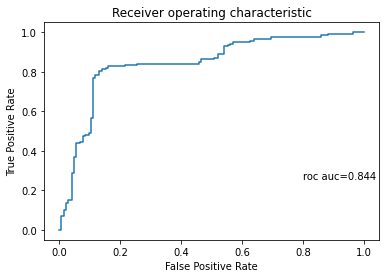

In [73]:
textstr = 'roc auc=%.3f\n'%(
    roc_auc
)
plt.text(0.8, 0.2, textstr, fontsize=10)
plt.plot(
    fpr, tpr
)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.show()

In [74]:
all_causal_scores

{0: -174.43529129243916,
 1: 46.57820890081689,
 2: 199.50630637324775,
 3: 483.84440604574183,
 4: 485.86846570184116,
 5: 0.00044819927506978274,
 6: -105.76567698455165,
 7: 246.94767753394308,
 8: 96.6975762375564,
 9: 52.513554362365085,
 10: 88.01258260557188,
 11: 275.30073146941504,
 12: 265.8113164030201,
 13: 53.15745135750876,
 14: 56.95979468729047,
 15: 112.38652414911212,
 16: 290.1910778807928,
 17: 316.02931302946763,
 18: 47.891447329951006,
 19: 215.3888040970346,
 20: 627.5070610433772,
 21: -112.8109797273487,
 22: 90.87698453280927,
 23: 204.37833805803302,
 24: 146.02489350031374,
 25: 324.60069375105604,
 26: 143.11418358207993,
 27: 308.5017538076686,
 28: 77.30508259091039,
 29: 49.80610474492869,
 30: -0.044035987540155475,
 31: 27.84115758059488,
 32: 76.59506410772565,
 33: -309.42807802645893,
 34: 632.9661765469632,
 35: 239.64598351482528,
 36: -149.12217601327166,
 37: 70.90422603785146,
 38: 235.09393473482578,
 39: 478.36325659278714,
 40: 205.89868544

In [75]:
all_scores

{0: ((2128.4078377417122, 1823.96135394605),
  (2115.9584689277044, 1661.9754314676188)),
 1: ((1929.8103761786342, -61.75844889076973),
  (2049.4320856685245, -134.80194947984296)),
 2: ((412.34343836087646, 1362.3203269417513),
  (1887.9540364991617, -312.7965775697817)),
 3: ((1668.2041015263112, 1697.9221187099115),
  (1923.9989361792377, 958.2828780112432)),
 4: ((2128.4078229321153, -676.5197100088071),
  (969.730571579541, 968.0260070456084)),
 5: ((2128.4078387861496, -1397.3854091982557),
  (2128.407821692609, -1397.3849439054402)),
 6: ((1936.623588163493, 48.89813510743761),
  (2059.0431948454243, -179.28714855904536)),
 7: ((989.0543981044193, 1168.2874826743127),
  (2128.4078611159325, -218.01365787114355)),
 8: ((1917.7616510809312, 289.46526097846345),
  (2067.6411928364378, 236.28329546051327)),
 9: ((2037.0878953224374, 1391.8230330573656),
  (1897.484934194309, 1478.9124398231288)),
 10: ((1937.978177482918, 328.5057294279759),
  (2079.6472224171557, 274.8492670993100

In [14]:
wrong_idx

[0,
 6,
 21,
 30,
 33,
 36,
 54,
 65,
 76,
 89,
 91,
 92,
 100,
 103,
 114,
 116,
 119,
 127,
 133,
 134,
 139,
 144,
 147,
 148,
 150,
 156,
 157,
 161,
 184,
 185,
 191,
 201,
 208,
 211,
 213,
 219,
 228,
 233,
 263,
 264,
 266,
 267,
 281,
 284]

0


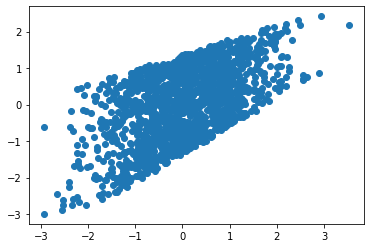

6


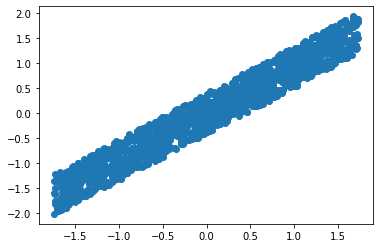

21


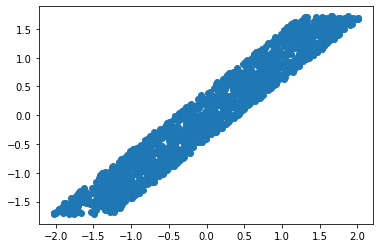

30


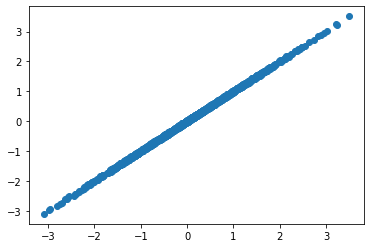

33


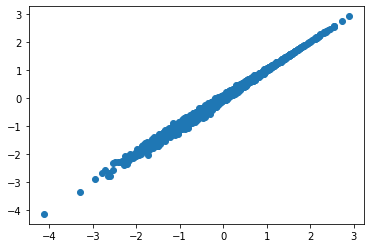

36


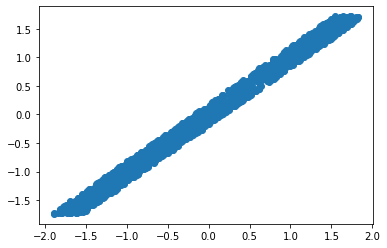

54


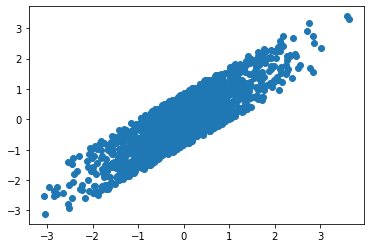

65


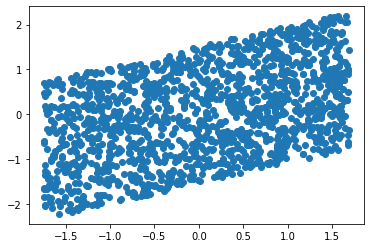

76


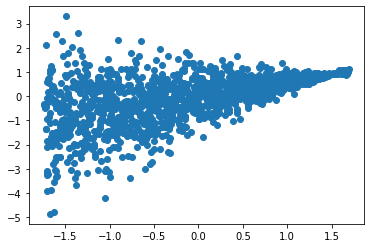

89


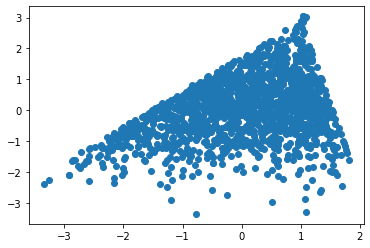

91


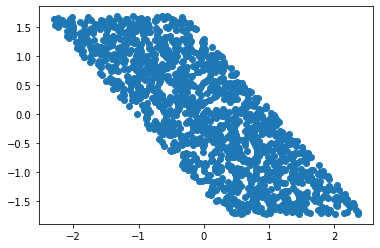

92


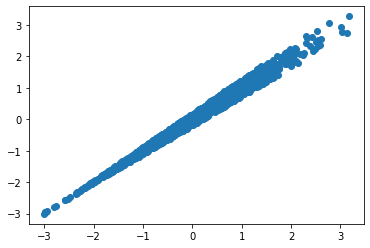

100


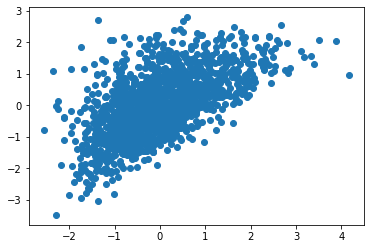

103


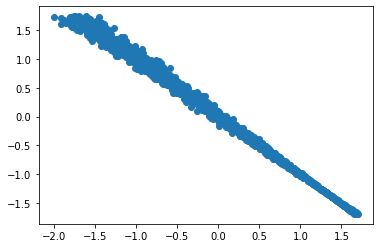

127


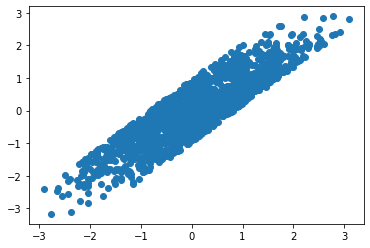

133


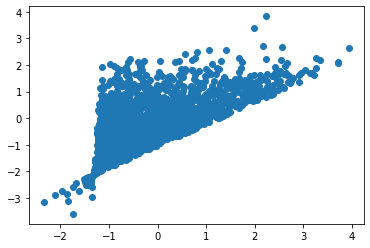

134


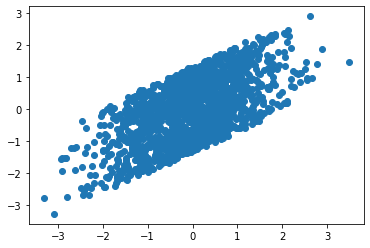

144


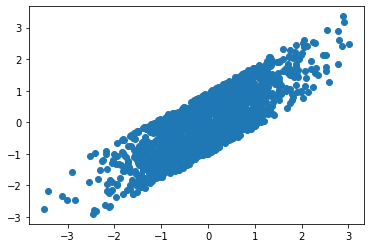

147


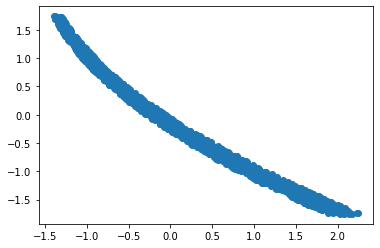

148


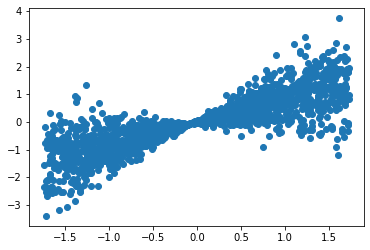

150


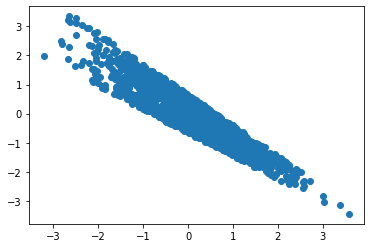

156


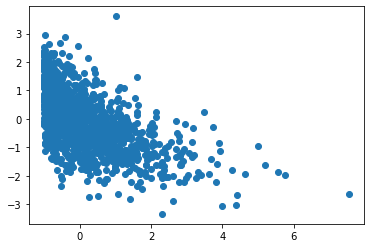

161


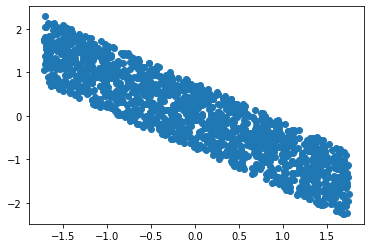

184


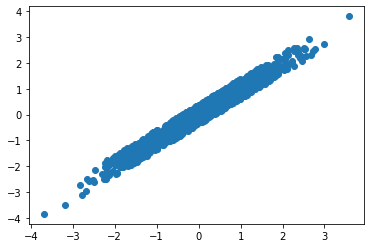

185


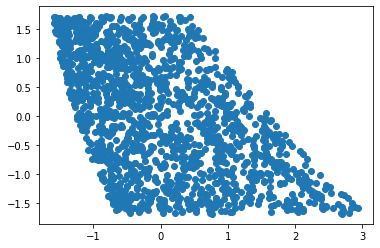

191


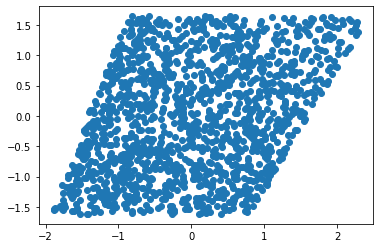

201


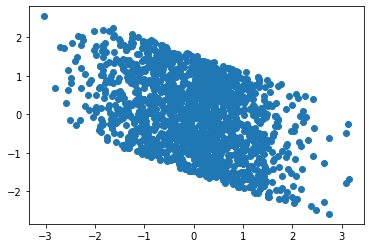

208


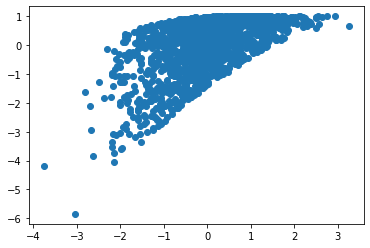

211


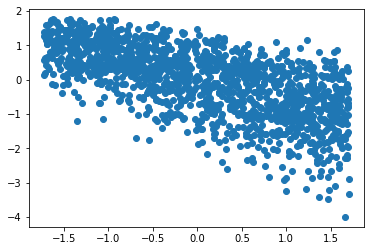

213


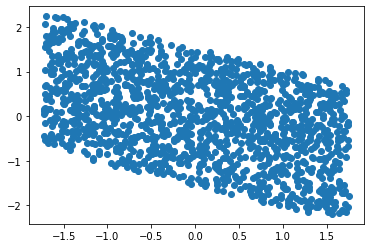

228


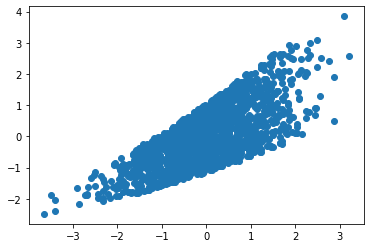

263


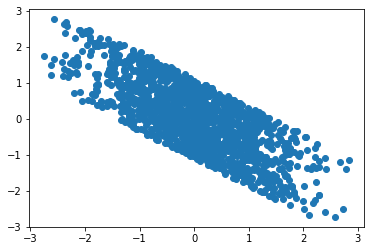

264


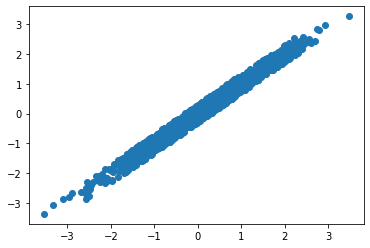

266


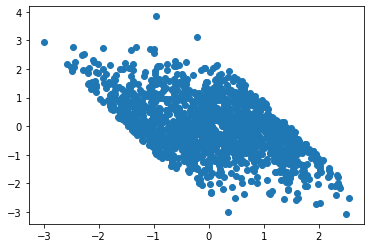

267


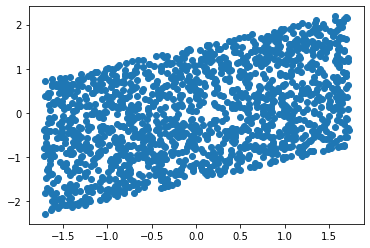

281


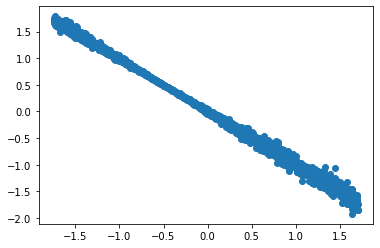

284


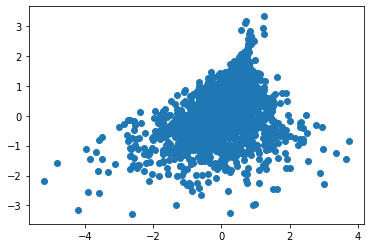

In [17]:
for i in wrong_idx:
    print(i)
    input, output = x[i], y[i]
    plt.scatter(input[:, 0], output[:, 0])
    plt.show()
    plt.close()

0.7586206896551724